
# Data preparation: exploration and normalization

- The start point was to observe and analyze the tables in the dataset to understand how the data is distributed (Pandas libraries for Python is used to handle the tables as dataframes).
- The common functions of Pandas DataFrame to use for an overview of the table are the following:

  ``` python
  dataframe.info()
  dataframe.head()
  dataframe.describe()
  ```

- After reviewing the contents of the various tables in the MIMIC database, only some tables were selected and loaded into DataFrames using Pandas because it was assumed that it wasn't necessary or useful for prediction to include all tables. 

So the table selected that compose the baseline dataset are the following:
- **ADMISSIONS.csv** that defines a patient’s hospital admission,   
- **PATIENTS.csv** that defines a single patient, 
- **DIAGNOSES_ICD.csv** that contains ICD diagnoses for patients, most notably ICD-9 diagnoses (after this matter will be better explained),

Other tables will be considered, if necessary for the specific task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### ADMISSIONS table

In [2]:
mimic4_path = '../../mimic-iv-1.0/'

# read admissions table
def read_admissions_table(mimic4_path):
    admits = pd.read_csv(mimic4_path + 'core/admissions.csv')
    # Pre-emptively don't include some columns that I don't need
    admits = admits[['subject_id','hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'insurance', 'ethnicity']]
    # Converts dates to a proper format
    admits.admittime = pd.to_datetime(admits.admittime)
    admits.dischtime = pd.to_datetime(admits.dischtime)
    admits.deathtime = pd.to_datetime(admits.deathtime)
    return admits

admits = read_admissions_table(mimic4_path)
admits.head()

subject_id   hadm_id           admittime           dischtime deathtime  \
0    14679932  21038362 2139-09-26 14:16:00 2139-09-28 11:30:00       NaT   
1    15585972  24941086 2123-10-07 23:56:00 2123-10-12 11:22:00       NaT   
2    11989120  21965160 2147-01-14 09:00:00 2147-01-17 14:25:00       NaT   
3    17817079  24709883 2165-12-27 17:33:00 2165-12-31 21:18:00       NaT   
4    15078341  23272159 2122-08-28 08:48:00 2122-08-30 12:32:00       NaT   

  admission_type insurance               ethnicity  
0       ELECTIVE     Other                 UNKNOWN  
1       ELECTIVE     Other                   WHITE  
2       ELECTIVE     Other                 UNKNOWN  
3       ELECTIVE     Other                   OTHER  
4       ELECTIVE     Other  BLACK/AFRICAN AMERICAN

In [3]:
admits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523740 entries, 0 to 523739
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   subject_id      523740 non-null  int64         
 1   hadm_id         523740 non-null  int64         
 2   admittime       523740 non-null  datetime64[ns]
 3   dischtime       523740 non-null  datetime64[ns]
 4   deathtime       9337 non-null    datetime64[ns]
 5   admission_type  523740 non-null  object        
 6   insurance       523740 non-null  object        
 7   ethnicity       523740 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(3)
memory usage: 32.0+ MB


When DEATHTIME in ADMISSIONS is not null then the patient associated died at the hospital, so we mark this distinction with a boolean variable.

In [4]:
admits['died_at_the_hospital'] = admits['deathtime'].notnull().map({True:1, False:0})

#### Reduction number of categories

In [5]:
# ETHNICITY
admits['ethnicity'].value_counts()

WHITE                            337630
BLACK/AFRICAN AMERICAN            80293
HISPANIC/LATINO                   29823
OTHER                             26813
ASIAN                             24506
UNKNOWN                           19400
UNABLE TO OBTAIN                   3740
AMERICAN INDIAN/ALASKA NATIVE      1535
Name: ethnicity, dtype: int64

We could reduce the number of categoruies just by considering the main categories or super-categories.

In [6]:
# Compress the number of ethnicity categories
admits['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
admits['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
admits['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
admits['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
admits['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
#take into consideration just the top-5 categories with biggest value_count, the others will fall into OTHER category
admits['ethnicity'].loc[~admits['ethnicity'].isin(admits['ethnicity'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'  
admits['ethnicity'].value_counts()

C:\Users\nicod\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


WHITE                     337630
BLACK/AFRICAN AMERICAN     80293
OTHER/UNKNOWN              51488
HISPANIC/LATINO            29823
ASIAN                      24506
Name: ethnicity, dtype: int64

Now let's do the same analysis done for ETHNICITY also for other attributes, if necessary, to reduce the number of possible categories.

In [7]:
# ADMISSION_TYPE
admits['admission_type'].value_counts()

EW EMER.                       157896
EU OBSERVATION                 100445
ELECTIVE                        72072
OBSERVATION ADMIT               55497
URGENT                          47930
SURGICAL SAME DAY ADMISSION     41074
DIRECT EMER.                    21581
DIRECT OBSERVATION              19991
AMBULATORY OBSERVATION           7254
Name: admission_type, dtype: int64

The category URGENT is a lot similar semantically to EMERGENCY or DIRECT EMERGENCY, so could combine these categories in EMERGENCY. We could do the same process also for all those categories that are related to OBSERVATION.

In [8]:
# Compresse into EMERGENCY
admits['admission_type'].replace(to_replace='EW EMER.', value='EMERGENCY', inplace=True)
admits['admission_type'].replace(to_replace='DIRECT EMER.', value='EMERGENCY', inplace=True)
admits['admission_type'].replace(to_replace='URGENT', value='EMERGENCY', inplace=True)
admits['admission_type'].value_counts()

EMERGENCY                      227407
EU OBSERVATION                 100445
ELECTIVE                        72072
OBSERVATION ADMIT               55497
SURGICAL SAME DAY ADMISSION     41074
DIRECT OBSERVATION              19991
AMBULATORY OBSERVATION           7254
Name: admission_type, dtype: int64

In [9]:
# Compresse into EMERGENCY
admits['admission_type'].replace(to_replace='EU OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='OBSERVATION ADMIT', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='DIRECT OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='AMBULATORY OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].value_counts()

EMERGENCY                      227407
OBSERVATION                    183187
ELECTIVE                        72072
SURGICAL SAME DAY ADMISSION     41074
Name: admission_type, dtype: int64

### PATIENTS table


In [10]:
# read patients table
def read_patients_table(mimic4_path):
    pats = pd.read_csv(mimic4_path + 'core/patients.csv')
    # Pre-emptively don't include some columns that I don't need
    pats = pats[['subject_id', 'gender', 'anchor_age', 'dod']]
    pats.dod = pd.to_datetime(pats.dod)
    return pats

patients = read_patients_table(mimic4_path)
patients.head()

subject_id gender  anchor_age dod
0    10000048      F          23 NaT
1    10002723      F           0 NaT
2    10003939      M           0 NaT
3    10004222      M           0 NaT
4    10005325      F           0 NaT

In PATIENTS table we have now the age of the patient and this is a news in comparison to MIMIC-3 where the age of the patient had to be computed.

So, let's have a look on the age distribution between patients.

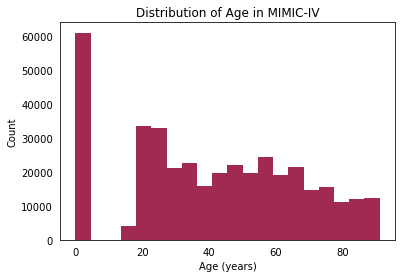

In [11]:
# DOB has been shifted for patients older than 89 to obscure their age and comply with HIPAA, the median age for the patients whose date of birth was shifted is 91.4

#let's see the distribution of age
plt.hist(patients['anchor_age'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

As we can see from age distribution, patients in their childhood are not present, this reflects the fact that MIMIC-IV as MIMIC-III does not contain data from pediatric patients.

Let's see also the distribution of gender.

In [17]:
patients['gender'].value_counts()

F    199707
M    182571
Name: gender, dtype: int64

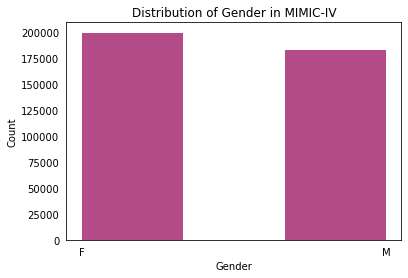

In [16]:
# distribution of gender
plt.hist(patients['gender'], bins=3, color='#b24b88')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Distribution of Gender in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

Wee can see how the gender is almost equally balanced.

Now we merge patients and admissions tables on 'subject_id' link.

In [19]:
# merge the PATIENTS table with ADMISSIONS table
admits_patients = pd.merge(admits, patients, how='inner', on='subject_id')
admits_patients.head()

subject_id   hadm_id           admittime           dischtime deathtime  \
0    14679932  21038362 2139-09-26 14:16:00 2139-09-28 11:30:00       NaT   
1    15585972  24941086 2123-10-07 23:56:00 2123-10-12 11:22:00       NaT   
2    11989120  21965160 2147-01-14 09:00:00 2147-01-17 14:25:00       NaT   
3    17817079  24709883 2165-12-27 17:33:00 2165-12-31 21:18:00       NaT   
4    15078341  23272159 2122-08-28 08:48:00 2122-08-30 12:32:00       NaT   

  admission_type insurance               ethnicity  died_at_the_hospital  \
0       ELECTIVE     Other           OTHER/UNKNOWN                     0   
1       ELECTIVE     Other                   WHITE                     0   
2       ELECTIVE     Other           OTHER/UNKNOWN                     0   
3       ELECTIVE     Other           OTHER/UNKNOWN                     0   
4       ELECTIVE     Other  BLACK/AFRICAN AMERICAN                     0   

  gender  anchor_age dod  
0      F           0 NaT  
1      F           0 NaT  
2      M           0 NaT  
3      F           0 NaT  
4      M           0 NaT

### DIAGNOSES_ICD table

In [20]:
# read diagnoses_icd table
def read_diagnoses_icd_table(mimic4_path):
    diag_icds = pd.read_csv(mimic4_path + 'hosp/diagnoses_icd.csv')
    return diag_icds

diag_icds = read_diagnoses_icd_table(mimic4_path)
diag_icds.head()

subject_id   hadm_id  seq_num icd_code  icd_version
0    15734973  20475282        3     2825            9
1    15734973  20475282        2    V0251            9
2    15734973  20475282        5     V270            9
3    15734973  20475282        1    64891            9
4    15734973  20475282        4    66481            9

In [21]:
diag_icds.count()

subject_id     5280351
hadm_id        5280351
seq_num        5280351
icd_code       5280351
icd_version    5280351
dtype: int64

In [22]:
diag_icds.icd_version.value_counts()

9     3090370
10    2189981
Name: icd_version, dtype: int64

We can notice that there are two version of icd_code: version 9 and 10. In general, ICD-10 codes are more detailed, but they could be mapped and converted to ICD-9 because they expresse the same concept.

Since we are dealing with a dataframe with a lot of entries and in any case it should later be reduced in size for a faster test, for simplicity we consider only the diagnoses with ICD9 codes.

In [23]:
diag_icds = diag_icds[diag_icds['icd_version'] == 9]
diag_icds.icd_version.value_counts()

9    3090370
Name: icd_version, dtype: int64

International Classification of Diseases, Clinical Modification (ICD-CM in version 9 and 10) is an adaption created by the U.S. National Center for Health Statistics (NCHS) and used in assigning diagnostic and procedure codes associated with inpatient, outpatient, and physician office utilization in the United States.

In [24]:
print('There are {} unique ICD9 codes in this dataset.'.format(diag_icds['icd_code'].value_counts().count()))

There are 9534 unique ICD9 codes in this dataset.


Because it's not feasible to have all these unique values to use as features for predicting LOS, it is necessary to reduce the diagnosis into more general categories. After researching the ICD9 and ICD10 approach, it's been noticed that they are arranged into super categories as described at the following links:

- **ICD-9 codes supercategories**: https://en.wikipedia.org/wiki/List_of_ICD-9_codes
- **ICD-10 codes supercategories**: https://en.wikipedia.org/wiki/ICD-10#Chapters

From this research we see that our attention could be just on the first 3 values to discover the supercategory. So our task now is to recode each ICD code considedred to its supercategory.

In [25]:
# Filter out E and V codes from ICD9 codes since processing will be done on the numeric first 3 values
diag_icds['recode'] = diag_icds['icd_code']
diag_icds['recode'] = diag_icds['recode'][~diag_icds['recode'].str.contains("[a-zA-Z]").fillna(False)]
diag_icds['recode'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 integers of the ICD9 code
diag_icds['recode'] = diag_icds['recode'].str.slice(start=0, stop=3, step=1)
diag_icds['recode'] = diag_icds['recode'].astype(int)
diag_icds.head()

subject_id   hadm_id  seq_num icd_code  icd_version  recode
0    15734973  20475282        3     2825            9     282
1    15734973  20475282        2    V0251            9     999
2    15734973  20475282        5     V270            9     999
3    15734973  20475282        1    64891            9     648
4    15734973  20475282        4    66481            9     664

In [26]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['recode'] = np.where(diag_icds['recode'].between(cat_range[0],cat_range[1]), num, diag_icds['recode'])
    
# Convert integer to category name using diag_dict
diag_icds['super_category'] = diag_icds['recode'].replace(diag_dict)
diag_icds.head()

subject_id   hadm_id  seq_num icd_code  icd_version  recode super_category
0    15734973  20475282        3     2825            9       3          blood
1    15734973  20475282        2    V0251            9      16         injury
2    15734973  20475282        5     V270            9      16         injury
3    15734973  20475282        1    64891            9      10      pregnancy
4    15734973  20475282        4    66481            9      10      pregnancy

For each admission, usually there is more than one diagnosis. Often, there are more than 1 diagnoses for 1 category. 

We could create a matrix that highlights all the diagnoses for each admission. This should not be done on the SUBJECT_ID since each patient could have different diagnoses for each admission.

In [28]:
# Create list of diagnoses for each admission
hadm_list = diag_icds.groupby('hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()

hadm_id                                     super_category
0  20000019  [injury, blood, respiratory, circulatory, endo...
1  20000041  [endocrine, digestive, endocrine, injury, musc...
2  20000055                                   [injury, injury]
3  20000057  [respiratory, injury, nervous, injury, injury,...
4  20000095                           [injury, injury, injury]

In [29]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

blood  circulatory  congenital  digestive  endocrine  genitourinary  \
0      1            1           1          0          3              2   
1      0            1           0          1          3              0   
2      0            0           0          0          0              0   
3      1            1           0          0          1              0   
4      0            0           0          0          0              0   

   infectious  injury  mental  misc  muscular  neoplasms  nervous  pregnancy  \
0           1       2       0     0         0          0        0          0   
1           0       4       0     0         1          0        0          0   
2           0       2       0     0         0          0        0          0   
3           0       7       0     1         5          0        4          0   
4           0       3       0     0         0          0        0          0   

   prenatal  respiratory  skin  
0         0            1     0  
1         0            0     0  
2         0            0     0  
3         1            2     0  
4         0            0     0

In [30]:
# Join back with HADM_ID
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

In [31]:
# Merge with main dataframe
admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='hadm_id')
admits_patients_diag.head()

subject_id   hadm_id           admittime           dischtime deathtime  \
0    14679932  21038362 2139-09-26 14:16:00 2139-09-28 11:30:00       NaT   
1    15585972  24941086 2123-10-07 23:56:00 2123-10-12 11:22:00       NaT   
2    15078341  23272159 2122-08-28 08:48:00 2122-08-30 12:32:00       NaT   
3    17301855  29732723 2140-06-06 14:23:00 2140-06-08 14:25:00       NaT   
4    17991012  24298836 2181-07-10 20:28:00 2181-07-12 15:49:00       NaT   

  admission_type insurance               ethnicity  died_at_the_hospital  \
0       ELECTIVE     Other           OTHER/UNKNOWN                     0   
1       ELECTIVE     Other                   WHITE                     0   
2       ELECTIVE     Other  BLACK/AFRICAN AMERICAN                     0   
3       ELECTIVE     Other                   WHITE                     0   
4       ELECTIVE     Other                   WHITE                     0   

  gender  ...  injury mental  misc  muscular  neoplasms  nervous  pregnancy  \
0      F  ...       2      0     0         0          0        0          0   
1      F  ...       2      0     0         0          0        0          0   
2      M  ...       3      0     0         0          0        0          0   
3      F  ...       2      0     0         0          0        0          0   
4      M  ...       2      0     0         0          0        0          0   

   prenatal  respiratory  skin  
0         0            0     0  
1         0            0     0  
2         0            0     0  
3         1            0     0  
4         0            0     0  

[5 rows x 29 columns]

In [32]:
# save this version of the dataframe to a csv. It will be used as baseline for our prediction tasks
admits_patients_diag.to_csv('admits_patients_diag.csv')